In [2]:
import json
import numpy as np
import parmed as pmd
import matplotlib.pyplot as plt

from paprika.analysis import fe_calc
from paprika.io import load_restraints, NumpyEncoder

### Load data

In [4]:
free_energy = fe_calc()
free_energy.temperature = 298.15
free_energy.prmtop = "restrained.pdb"
free_energy.trajectory = f'production-v1.dcd'
free_energy.path = "windows"
free_energy.restraint_list = load_restraints(filepath='restraints.json')
free_energy.collect_data()

### Estimate Overlap between umbrella windows

In [5]:
def return_intersection(hist1, hist2):
    minima = np.minimum(hist1, hist2)
    intersect_1 = np.true_divide(np.sum(minima), np.sum(hist1))
    intersect_2 = np.true_divide(np.sum(minima), np.sum(hist2))
    return np.array([intersect_1, intersect_2])

In [22]:
trajectory = free_energy.simulation_data["pull"]
n_windows = np.shape(trajectory)[0]
n_bins = 30
overlap = np.zeros(n_windows)

for j in range(n_windows-1):
    min_x = np.min(trajectory[j][0])
    max_x = np.max(trajectory[j+1][0])
    hist1, _ = np.histogram(trajectory[j][0],   bins=n_bins, range=[min_x, max_x])
    hist2, _ = np.histogram(trajectory[j+1][0], bins=n_bins, range=[min_x, max_x])
    intersection = return_intersection(hist1, hist2)
    overlap[j] = intersection[0]
overlap[-1] = intersection[1]

### Plot overlap

Text(0, 0.5, 'overlap')

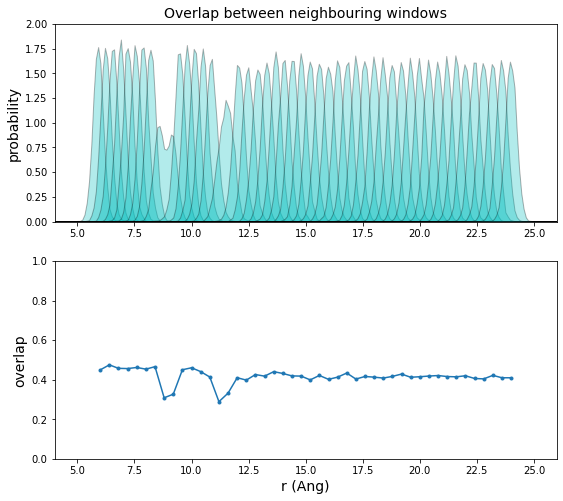

In [42]:
plt.figure(figsize=(9,8))

ax1 = plt.subplot(211)
ax1.clear()
ax1.axis([4.0, 26.0, 0.0, 2.0])
ax1.set_ylabel("probability", fontsize=14)
ax1.set_title("Overlap between neighbouring windows", fontsize=14)

for i in range(len(free_energy.simulation_data["pull"])):
    hist, bins = np.histogram(
        free_energy.simulation_data["pull"][i][0],
        bins=301,
        range=(0,30),
        density=True
    )
    center = (bins[:-1] + bins[1:]) / 2
    ax1.fill_between(
        center, hist*0.0, hist, facecolor='c', edgecolor='k',
        alpha=0.3, #zorder=zorder
    )
    
ax2 = plt.subplot(212)
ax2.clear()
ax2.axis([4.0,26.0,0.0,2.0])
pull_distance = np.linspace(6, 24, 46)
ax2.plot(pull_distance, overlap, '.-')
ax2.set_ylim(0, 1)
ax2.set_xlabel("r (Ang)", fontsize=14)
ax2.set_ylabel("overlap", fontsize=14)